In [258]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import jax

from jax import random, jit, vmap, grad
from jax import numpy as jnp
from jax.lax import cond

import astropy
import numpy as np
import healpy as hp

import h5py
import astropy.units as u

from astropy.cosmology import Planck15, FlatLambdaCDM, z_at_value
import astropy.constants as constants
from jax.scipy.special import logsumexp
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from tqdm import tqdm

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)
matplotlib.rcParams['axes.unicode_minus'] = False

import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')
c=sns.color_palette('colorblind')

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_default_matmul_precision', 'highest')


In [259]:
import h5py

filename = '../../../../gws-agn/data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/lognormal_pixelated_nside_256_galaxies.h5'

nside = 256

#biased 0.05, 0.01, 0.005 [0.001 or better unbiased]
with h5py.File(filename, 'r') as f:
    zgals = jnp.asarray(f['zgals'])
    dzgals = 0.0001*(1+zgals)
    wgals = jnp.ones(zgals.shape)
    ngals = jnp.asarray(f['ngals'])
    
filename = '../../../../gws-agn/data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/lognormal_pixelated_nside_256_agn.h5'

with h5py.File(filename, 'r') as f:
    zagns = jnp.asarray(f['zagn'])
    dzagns = 0.0001*(1+zagns)
    wagns = jnp.ones(zagns.shape)
    nagns = jnp.asarray(f['nagn'])

print(ngals.sum(),nagns.sum())
    

1176983 1177354


In [260]:
from jaxinterp2d import interp2d, CartesianGrid

zMax_1 = 0.5
zMax_2 = 5

H0Planck = Planck15.H0.value
Om0Planck = Planck15.Om0

cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Planck15.Om0)
speed_of_light = constants.c.to('km/s').value

zgrid_1 = np.expm1(np.linspace(np.log(1), np.log(zMax_1+1), 5000))
zgrid_2 = np.expm1(np.linspace(np.log(zMax_1+1), np.log(zMax_2+1), 1000))
zgrid = np.concatenate([zgrid_1,zgrid_2])

rs = []
Om0grid = jnp.linspace(Om0Planck-0.1,Om0Planck+0.1,100)
for Om0 in tqdm(Om0grid):
    cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Om0)
    rs.append(cosmo.comoving_distance(zgrid).to(u.Mpc).value)

zgrid = jnp.array(zgrid)
rs = jnp.asarray(rs)
rs = rs.reshape(len(Om0grid),len(zgrid))

@jit
def E(z,Om0=Om0Planck):
    return jnp.sqrt(Om0*(1+z)**3 + (1.0-Om0))

@jit
def r_of_z(z,H0,Om0=Om0Planck):
    return interp2d(Om0,z,Om0grid,zgrid,rs)*(H0Planck/H0)

@jit
def dL_of_z(z,H0,Om0=Om0Planck):
    return (1+z)*r_of_z(z,H0,Om0)

@jit
def z_of_dL(dL,H0,Om0=Om0Planck):
    return jnp.interp(dL,dL_of_z(zgrid,H0,Om0),zgrid)

@jit
def dV_of_z(z,H0,Om0=Om0Planck):
    return speed_of_light*r_of_z(z,H0,Om0)**2/(H0*E(z,Om0))

@jit
def ddL_of_z(z,dL,H0,Om0=Om0Planck):
    return dL/(1+z) + speed_of_light*(1+z)/(H0*E(z,Om0))

100%|██████████| 100/100 [00:00<00:00, 226.14it/s]


In [302]:
f_true = 0.5
lam_true = 0.5

filename = '../../../../gws-agn/data/mocks_glass/mock_seed42_ratioNgalNagn1_bgal1.0_bagn1.0/gwsamples_fagn'+str(f_true)+'_lambdaagn'+str(lam_true)+'_N1000_seed1042_pos_only.h5'

with h5py.File(filename, 'r') as inp:
        nsamps = inp.attrs['nsamp']
        nEvents_ = inp.attrs['nobs']
        ra = jnp.array(inp['ra'])
        dec = jnp.array(inp['dec'])
        dL = jnp.array((jnp.array(inp['dL'])*u.Mpc).value)

nsamp = 10000
nEvents = 1000
ra = ra.reshape(nEvents_,nsamps)[0:nEvents,0:nsamp]
dec = dec.reshape(nEvents_,nsamps)[0:nEvents,0:nsamp]
dL = dL.reshape(nEvents_,nsamps)[0:nEvents,0:nsamp]
print(ra.shape)
ra = ra[0:nEvents].flatten()
dec = dec[0:nEvents].flatten()
dL = dL[0:nEvents].flatten()

p_pe = jnp.ones(len(dL))

print(nEvents,nsamp)
print(z_of_dL(dL,140,Om0grid[-1]).max())

(1000, 10000)
1000 10000
3.1298544357561635


In [303]:
import healpy as hp

npix = hp.pixelfunc.nside2npix(nside)
apix = hp.pixelfunc.nside2pixarea(nside)

print(npix)
samples_ind = hp.pixelfunc.ang2pix(nside,np.pi/2-dec,ra)

786432


In [304]:
@jit
def dV_of_z_normed(z,Om0,gamma):
    dV = dV_of_z(zgrid,H0Planck,Om0)*(1+zgrid)**(gamma-1)
    prob = dV/jnp.trapezoid(dV,zgrid)
    return jnp.interp(z,zgrid,prob)


In [305]:
from jax.scipy.stats import norm

@jit
def logdiffexp(x, y):
    return x + jnp.log1p(jnp.exp(y-x))

In [306]:
from jaxinterp2d import interp2d

@jit
def logpcatalog_gals(z, pix, Om0, gamma):
    zs = zgals[pix] 
    ddzs = dzgals[pix]
    wts = wgals[pix]*(1+zs)**(gamma)
    ngals = jnp.sum(zs != 100)
    wts = wts/jnp.sum(wts)
    return logsumexp(jnp.log(wts) + norm.logpdf(z,zs,ddzs)), ngals

logpcatalog_gals_vmap = jit(vmap(logpcatalog_gals, in_axes=(0,0,None,None), out_axes=0))

def logpcatalog_agns(z, pix, Om0, gamma):
    zs = zagns[pix] 
    ddzs = dzagns[pix]
    wts = wagns[pix]*(1+zs)**(gamma)
    nagns = jnp.sum(zs != 100)
    wts = wts/jnp.sum(wts)
    return logsumexp(jnp.log(wts) + norm.logpdf(z,zs,ddzs)), nagns

logpcatalog_agns_vmap = jit(vmap(logpcatalog_agns, in_axes=(0,0,None,None), out_axes=0))

import jax.numpy as jnp
from jax.scipy.special import logsumexp

def logPriorUniverse(z, pix, f, Om0, gamma_agn, gamma_gal):
    # Get log-prob catalogs and counts
    logpcat_agns, nagns = logpcatalog_agns_vmap(z, pix, Om0, gamma_agn)
    logpcat_gals, ngals = logpcatalog_gals_vmap(z, pix, Om0, gamma_gal)
    
    log_term1 = jnp.log(f) + logpcat_agns
    log_term2 = jnp.log1p(-f) + logpcat_gals
    
    log_prob = jnp.logaddexp(log_term1, log_term2)
    return log_prob


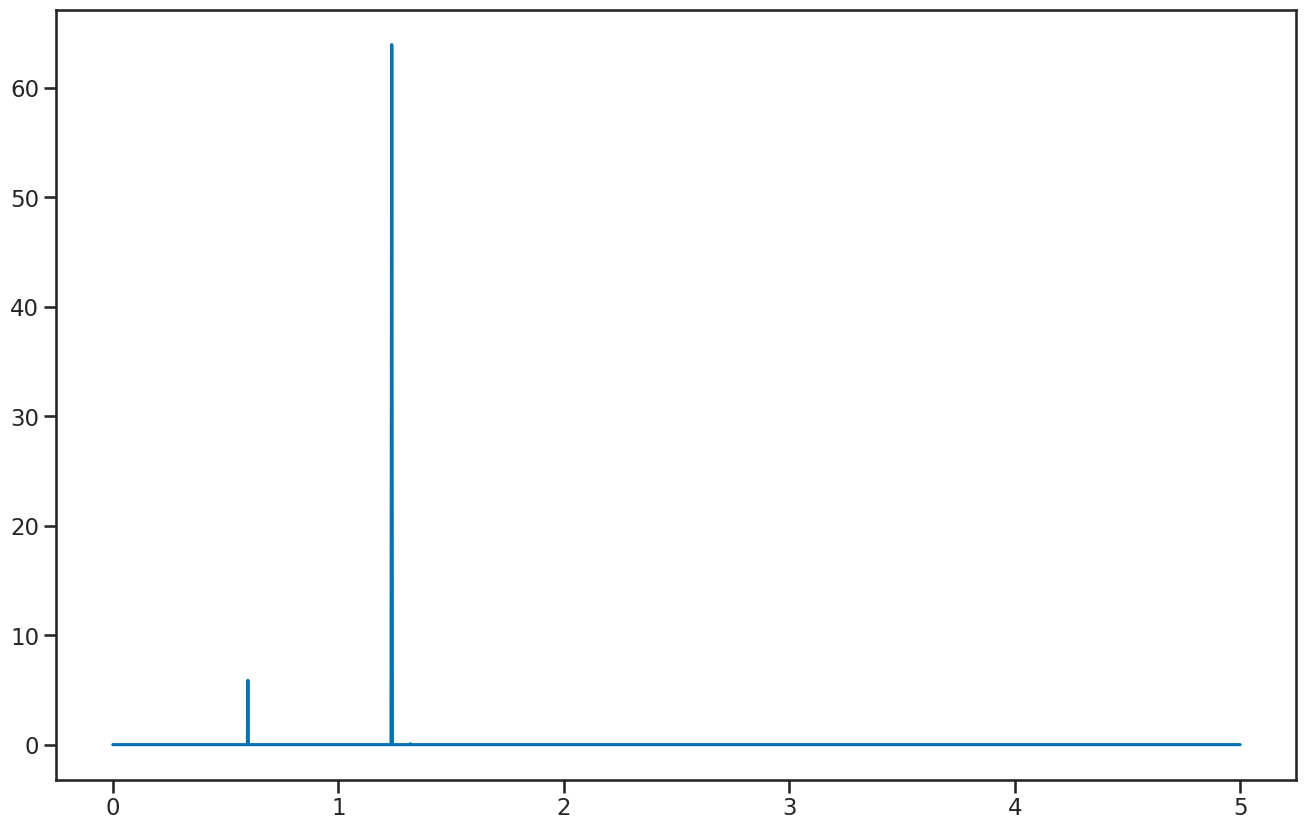

In [307]:
ll = logPriorUniverse(zgrid, jnp.ones(len(zgrid),dtype=int)*55000, 0.75, Om0Planck, 0, 0)

plt.plot(zgrid, jnp.exp(ll))
plt.show()

In [333]:
seed = np.random.randint(1000)
key = jax.random.PRNGKey(1000)

Om0 = Om0Planck
gamma_agn = 0
gamma_gal = 0

def darksiren_log_likelihood(H0,f):#,gamma_agn,gamma_gal):#,mu,sigma):
    z = z_of_dL(dL, H0, Om0)

    log_weights = - jnp.log(ddL_of_z(z,dL,H0,Om0)) - jnp.log(p_pe) + logPriorUniverse(z,samples_ind,f,Om0,gamma_agn,gamma_gal)

    log_weights = log_weights.reshape((nEvents,nsamp))
    ll = jnp.sum(-jnp.log(nsamp) + logsumexp(log_weights,axis=-1))
    
    return ll


In [327]:
darksiren_log_likelihood(H0=70,f=0.75,gamma_agn=0,gamma_gal=0)

Array(-15009.75963444, dtype=float64)

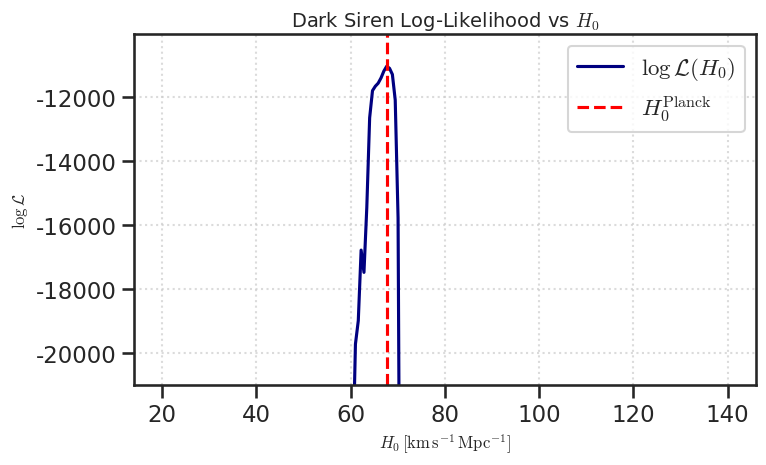

In [328]:
h0grid = jnp.linspace(20, 140, 200)

lls = []
for h0 in h0grid:
    lls.append(darksiren_log_likelihood(H0=h0, f=0.75,gamma_agn=0,gamma_gal=0))

lls = np.array(lls)

plt.figure(figsize=(8,5))
plt.plot(h0grid, lls, label=r'$\log \mathcal{L}(H_0)$', color='navy')
plt.axvline(H0Planck, color='red', linestyle='--', label=r'$H_0^{\rm Planck}$')

plt.xlabel(r'$H_0 \, [\mathrm{km \, s^{-1} \, Mpc^{-1}}]$', fontsize=12)
plt.ylabel(r'$\log \mathcal{L}$', fontsize=12)
plt.title("Dark Siren Log-Likelihood vs $H_0$", fontsize=14)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.ylim(lls.max()-10000,lls.max()+1000)
plt.tight_layout()
plt.show()


/tmp/ipykernel_2495913/1930156910.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


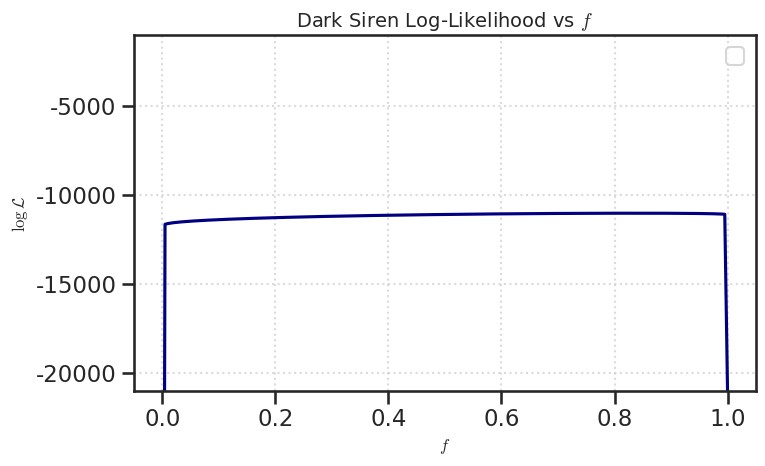

In [329]:
# f grid
fgrid = jnp.linspace(0, 1, 200)

# Compute log-likelihoods for each lambda
lls = [darksiren_log_likelihood(H0=H0Planck, f=f,gamma_agn=0,gamma_gal=0) for f in fgrid]

# Convert to numpy arrays
lls = np.array(lls)

# Plotting
plt.figure(figsize=(8,5))
plt.plot(fgrid, lls, color='navy', linestyle='-')
plt.ylim(lls.max()-10000,lls.max()+10000)
plt.xlabel(r'$f$', fontsize=12)
plt.ylabel(r'$\log \mathcal{L}$', fontsize=12)
plt.title(r"Dark Siren Log-Likelihood vs $f$", fontsize=14)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()


In [330]:
H0_lo = 20
H0_hi = 120

Om0_lo = Om0grid[0]
Om0_hi = Om0grid[-1] 

gamma_lo = -30
gamma_hi = 30

mu_lo = 20
mu_hi = 50

sigma_lo = 1
sigma_hi = 10

f_lo = 0
f_hi = 1

lam_lo = 0
lam_hi = 1

lower_bound = [H0_lo, f_lo]#,gamma_lo,gamma_lo]
upper_bound = [H0_hi, f_hi]#,gamma_hi,gamma_hi]

ndims = len(lower_bound)
nlive = 200

labels = [r'$H_0$',
          r'$f$']#,'gamma_agn','gamma_gal']

truths = [H0Planck,0.75]#,0,0]

def prior_transform(theta):
    transformed_params = [
        theta[i] * (upper_bound[i] - lower_bound[i]) + lower_bound[i] 
        for i in range(len(theta))
    ]
    
    return tuple(transformed_params)

def likelihood(coord):
    ll = darksiren_log_likelihood(*coord)
    if np.isnan(ll):
        return -np.inf
    else:
        return ll

def likelihood_emcee(coord):
    for i in range(len(coord)):
        if (coord[i]<lower_bound[i] or coord[i]>upper_bound[i]):
            return -np.inf
    ll = darksiren_log_likelihood(*coord)
    if np.isnan(ll):
        return -np.inf
    else:
        return ll

In [358]:
import emcee

n_walkers = 64
p0 = np.random.uniform(lower_bound, upper_bound, size=(n_walkers, len(lower_bound)))
n_steps = 1000

sampler = emcee.EnsembleSampler(n_walkers, ndims, likelihood_emcee,
                                moves=[
        (emcee.moves.DEMove(), 0.8),
        (emcee.moves.DESnookerMove(), 0.2),
    ])#, pool=pool)
sampler.run_mcmc(p0, n_steps, progress=True)

100%|██████████| 1000/1000 [38:27<00:00,  2.31s/it]


State([[67.65733264  0.82519323]
 [67.67616313  0.81670969]
 [67.6830294   0.76986249]
 [67.67624874  0.84874384]
 [67.67267026  0.82903869]
 [67.67111959  0.82933558]
 [67.68301786  0.8339733 ]
 [67.88056437  0.81471088]
 [67.68424597  0.80550927]
 [67.80218745  0.84545553]
 [67.67022821  0.83940545]
 [67.80892556  0.89370157]
 [67.69255402  0.8364204 ]
 [67.68417351  0.86227812]
 [67.67214055  0.88542699]
 [67.66366487  0.8504867 ]
 [67.67305122  0.82087403]
 [67.66963386  0.84857871]
 [67.67208567  0.84975105]
 [67.68808696  0.83196563]
 [67.6864724   0.85191982]
 [67.67877722  0.81815841]
 [67.67750262  0.83092207]
 [67.685715    0.85701662]
 [67.67745038  0.83941677]
 [67.68095664  0.81963149]
 [67.65787582  0.84253915]
 [67.68007489  0.83905614]
 [67.66477212  0.83787513]
 [67.65643001  0.84179672]
 [67.79999407  0.8347145 ]
 [67.66855677  0.84936014]
 [67.68279551  0.79529942]
 [67.68201801  0.83860015]
 [67.66770899  0.85498697]
 [67.67573688  0.79240792]
 [67.69305552  0.80601

In [366]:
shape = sampler.flatchain.shape[0]
print(shape)

dpostsamples_backup = sampler.flatchain[int(shape/2):,:]

shape = dpostsamples_backup.shape[0]
print(shape)
choose = np.random.randint(0,shape,10000)
choose

64000
32000


array([19245, 29439, 22868, ...,  5881,  1754, 11719])

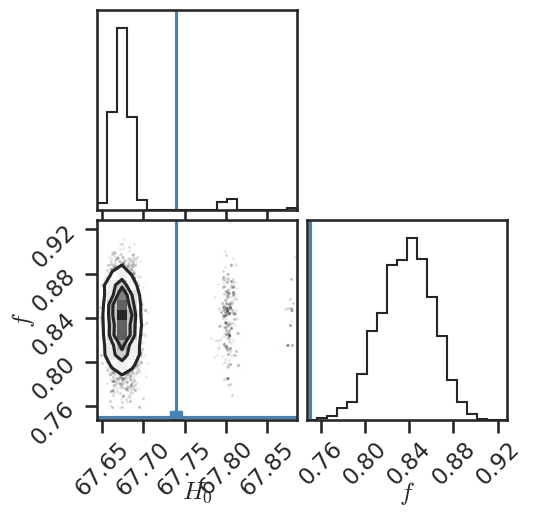

In [367]:
import corner

dpostsamples = dpostsamples_backup[choose]

ranges=[]
for k in range(len(lower_bound)):
    ranges.append((lower_bound[k],upper_bound[k]))
fig = corner.corner(dpostsamples, labels=labels, hist_kwargs={'density': True},truths=truths)
plt.show()

/tmp/ipykernel_2495913/1263212344.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dpostsamples[:,0])
/hildafs/home/magana/tmp_ondemand_hildafs_phy230014p_symlink/magana/.conda/envs/jax/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


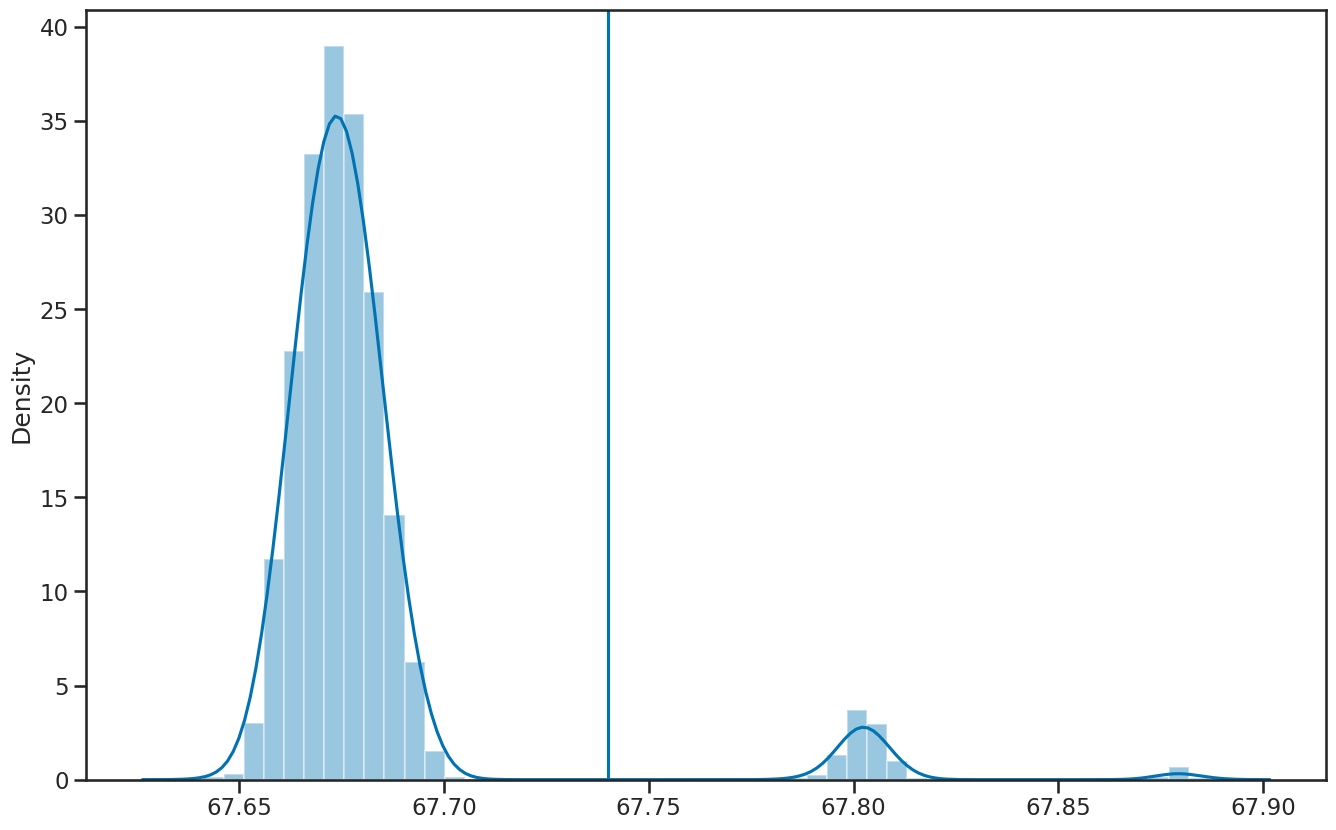

In [361]:
sns.distplot(dpostsamples[:,0])
plt.axvline(H0Planck)
plt.show()

/tmp/ipykernel_2495913/1823200420.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(f)
/hildafs/home/magana/tmp_ondemand_hildafs_phy230014p_symlink/magana/.conda/envs/jax/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


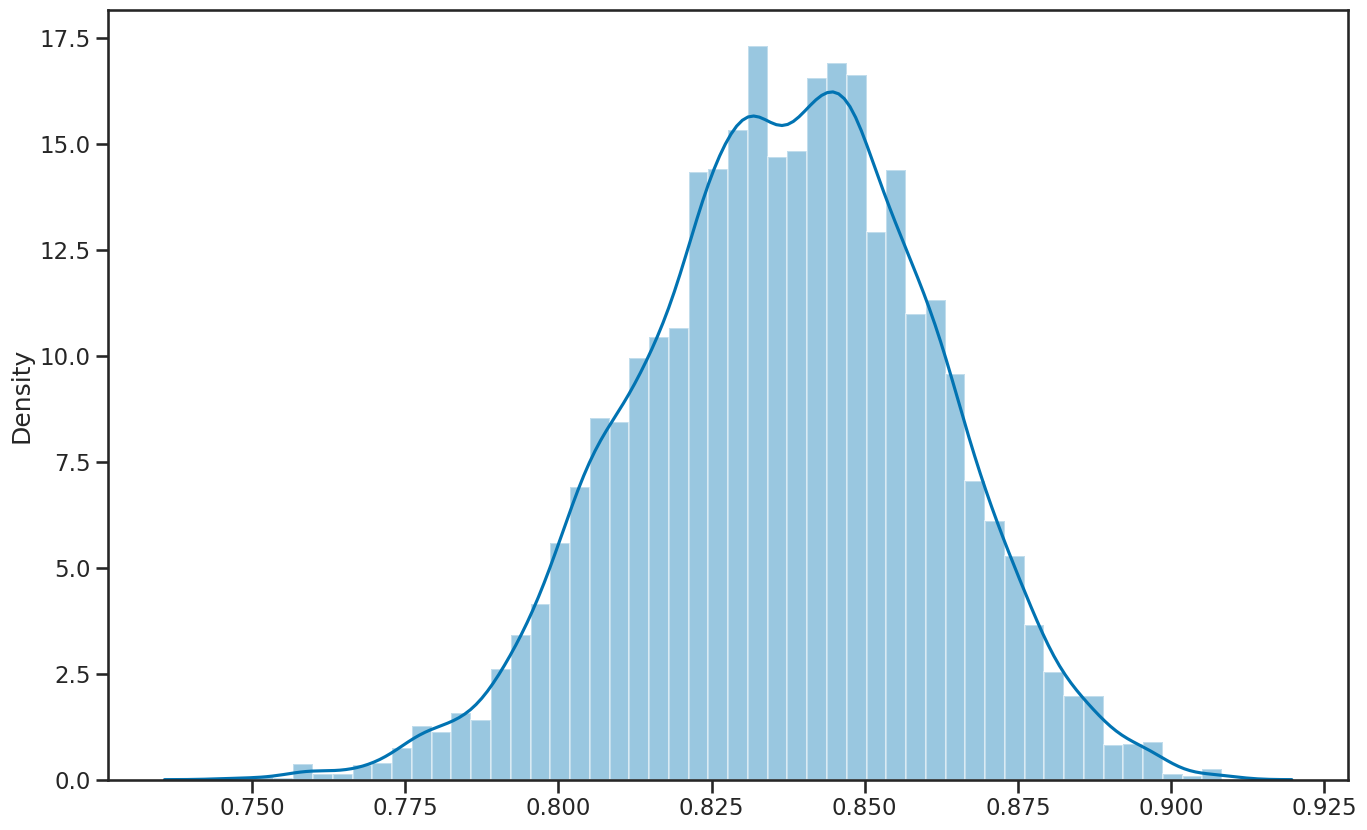

In [362]:
f = dpostsamples[:,1]

sns.distplot(f)
plt.show()

In [363]:
N_gal = ngals.sum()
N_agn = nagns.sum()

import numpy as np
from scipy.optimize import minimize

def model_frac_agn(f_agn, lambda_agn, N_gal, N_agn):
    W_agn = lambda_agn * N_agn
    W_gal = (1 - lambda_agn) * N_gal
    W_tot = W_agn + W_gal
    return f_agn + (1 - f_agn) * W_agn / W_tot

def solve_fagn_lambda(frac_agn_obs, N_gal, N_agn):
    def loss(params):
        f_agn, lambda_agn = params
        if not (0 <= f_agn <= 1 and 0 <= lambda_agn <= 1):
            return np.inf
        frac_model = model_frac_agn(f_agn, lambda_agn, N_gal, N_agn)
        return (frac_model - frac_agn_obs)**2

    # Initial guess: equal mixing and moderate AGN fraction
    x0 = [0.5, 0.5]
    bounds = [(0, 1), (0, 1)]

    result = minimize(loss, x0, bounds=bounds)
    if result.success:
        f_agn, lambda_agn = result.x
        return f_agn, lambda_agn
    else:
        raise RuntimeError("Optimization failed")

In [ ]:
fagns = []
lamsagns = []

for ff in f:
    fs,lams = solve_fagn_lambda(ff, N_gal, N_agn)
    print(fs,lams)
    fagns.append(fs)
    lamsagns.append(lams)

0.5869513725199672 0.5869651154035458
0.6008963746001823 0.6009123497246924
0.5593036725575639 0.5593130264025754
0.6053041576581326 0.6053208420555894
0.6001986230458806 0.6002144861045466
0.6337113568907309 0.6337326754774497
0.5609696534561837 0.5609792708555297
0.5781095105332211 0.5781218454552379
0.5692589585753423 0.5692698886770213
0.5847121835994772 0.5847255693709691
0.5629991064170944 0.5630090450163285
0.658322042472752 0.6583475091459555
0.6183723688830326 0.618391170178978
0.6068891970314494 0.6069061370953989
0.6302058572839881 0.6302265971632862
0.6140135231354836 0.6140316155381131
0.5899127859842391 0.589927001597124
0.6108340167848737 0.6108515943084111
0.6151973225285233 0.6152156074508588
0.6033592556511854 0.6033756268752052
0.5890557440139674 0.5890698224844916
0.5552269484725822 0.555235657789184
0.6443277645477241 0.6443508533535068
0.5510245319348934 0.5510325772789461
0.5536762571668548 0.5536847214298832
0.6118213052876137 0.6118390426969776
0.59477849474907

/tmp/ipykernel_2495913/2937892976.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fagns)
/hildafs/home/magana/tmp_ondemand_hildafs_phy230014p_symlink/magana/.conda/envs/jax/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_2495913/2937892976.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar fl

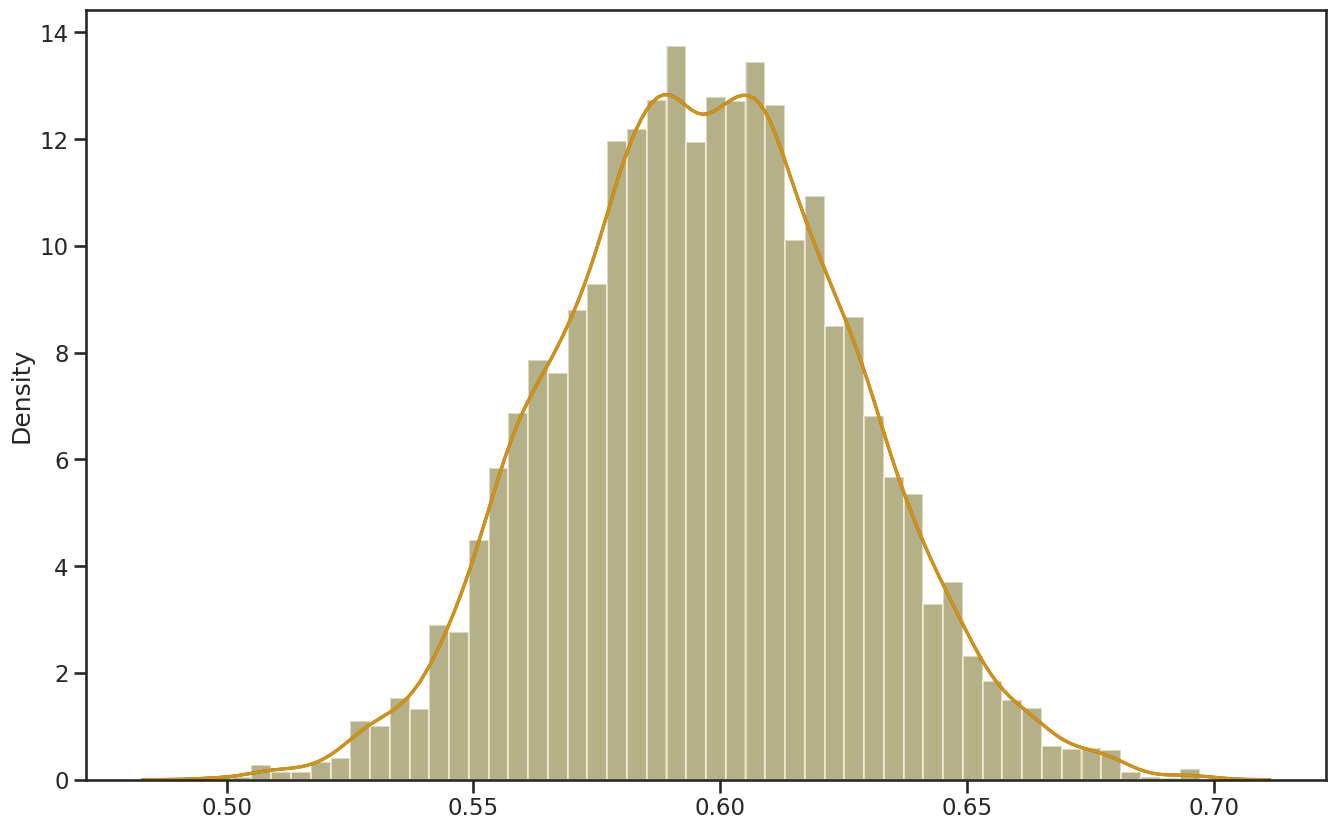

In [368]:
sns.distplot(fagns)
sns.distplot(lamsagns)
plt.show()